<a href="https://colab.research.google.com/github/pansplawik/eegParkinsonCognitiveDisorders/blob/master/secondVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import csv

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/dyplom/dataset.csv', sep=';')
path='/content/drive/MyDrive/dyplom/EEG'

In [ ]:
path='/content/drive/MyDrive/dyplom/EEG'
def load_epochs_from_dir(path, labels):
    epochs_array = []
    for filename, label in zip(os.listdir(path), labels['PD']):
        print(filename)
        if filename.endswith('.edf'):
            filepath = os.path.join(path, filename)
            raw = mne.io.read_raw_edf(filepath, preload=True)
            annotations = raw.annotations
            for i in range(len(annotations)):
              if annotations.description[i] == "break":
                annotations.description[i] = "BAD" 
              elif annotations.description[i] == 'Break end':
                annotations.description[i] = "BAD"
            raw.set_annotations(annotations)
            raw.filter(1, 40, fir_design='firwin')
            events = mne.make_fixed_length_events(raw, duration=1.0)
            epochs = mne.Epochs(raw, events, tmin=0, tmax=2, baseline=(0,2), detrend=1, reject_by_annotation='BAD',preload=True)
            epochs_array.append([epochs, label])
            epochs.plot_drop_log()
            del epochs
            del raw
            del annotations
    return epochs_array


In [ ]:
def psds(epochs_array, labels):
    data = []
    for epochs, label in zip(epochs_array, labels):
        epo_spectrum = epochs.compute_psd(method='multitaper', fmin=8, fmax=13, picks='eeg')
        psds, freqs = epo_spectrum.get_data(return_freqs=True)
        for p in psds:
            data.append([p, label])
        del psds
        del freqs
    return data

PD130.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD130.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 658943  =      0.000 ...  1286.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1287 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1287 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


21 bad epochs dropped


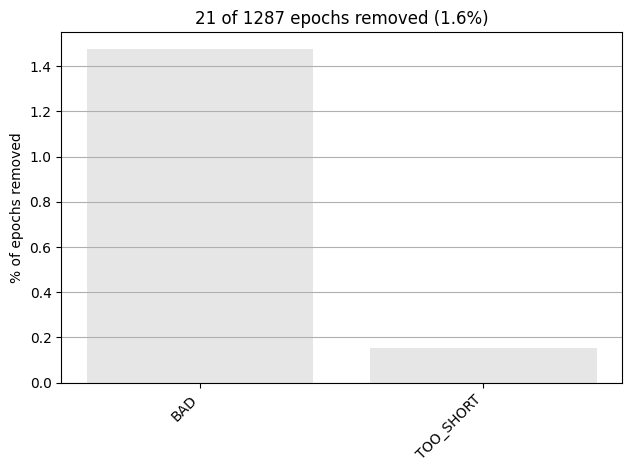

PD129.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 755199  =      0.000 ...  1474.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1475 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1475 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


267 bad epochs dropped


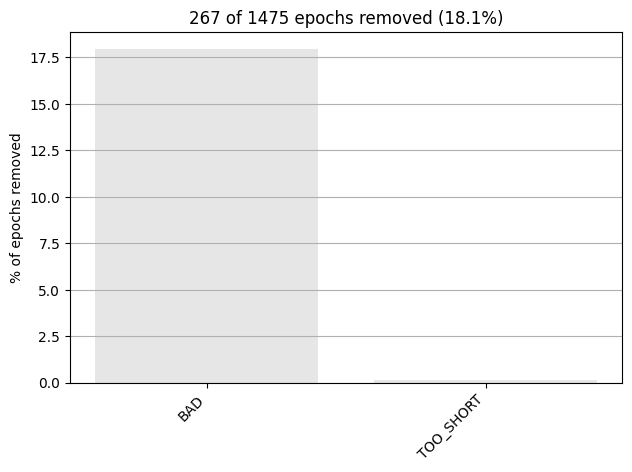

PD131.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD131.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671231  =      0.000 ...  1310.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1311 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1311 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


89 bad epochs dropped


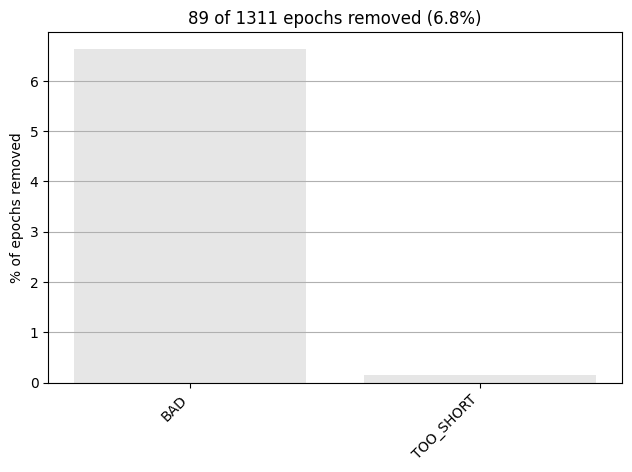

PD135.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD135.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 635903  =      0.000 ...  1241.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1242 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1242 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


14 bad epochs dropped


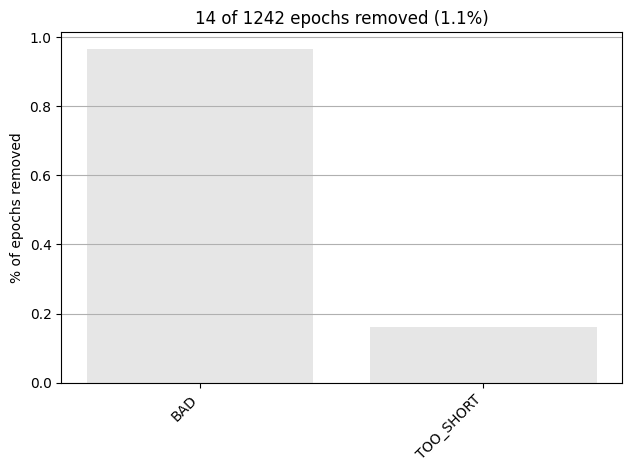

PD132.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 673279  =      0.000 ...  1314.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1315 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1315 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


31 bad epochs dropped


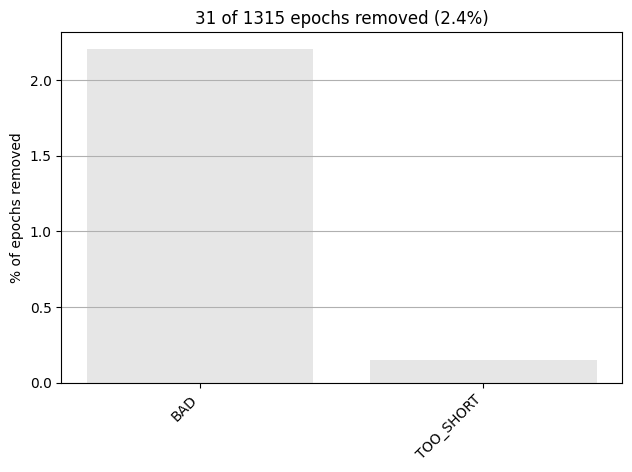

PD138.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD138.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 629247  =      0.000 ...  1228.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1229 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1229 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


14 bad epochs dropped


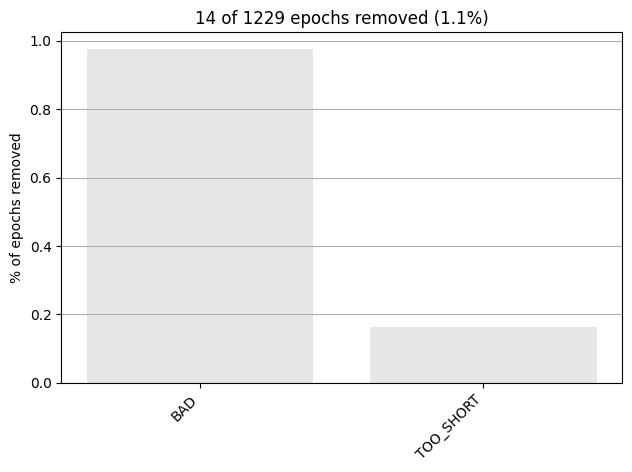

PD136.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD136.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 641535  =      0.000 ...  1252.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1253 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


21 bad epochs dropped


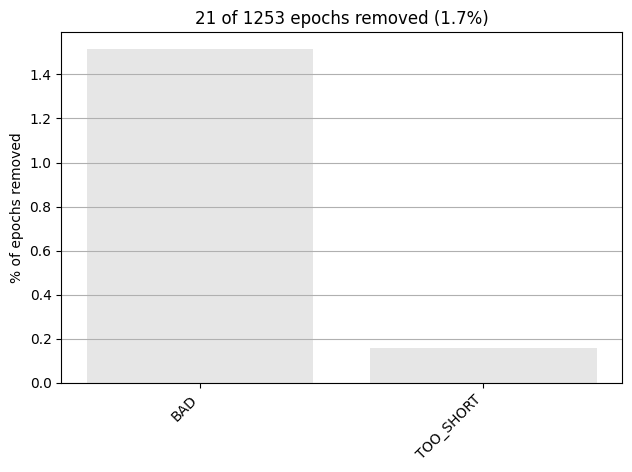

PD134.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD134.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 625663  =      0.000 ...  1221.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1222 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1222 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


20 bad epochs dropped


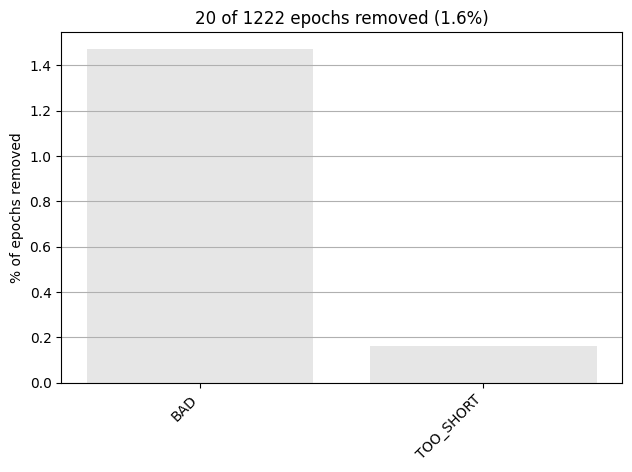

PD133.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD133.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 662527  =      0.000 ...  1293.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1294 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1294 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


19 bad epochs dropped


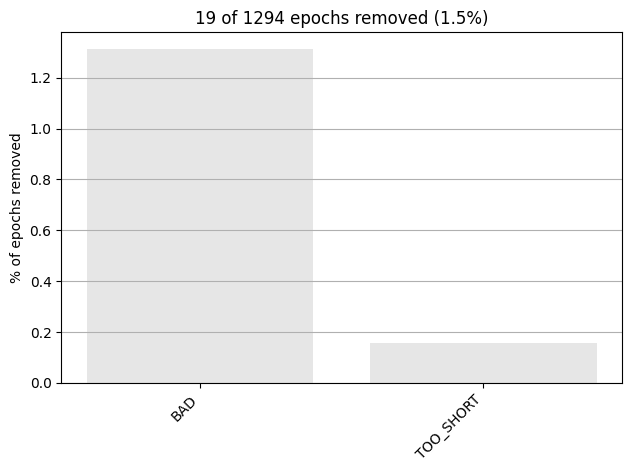

PD137.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD137.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 635391  =      0.000 ...  1240.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1241 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1241 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


2 bad epochs dropped


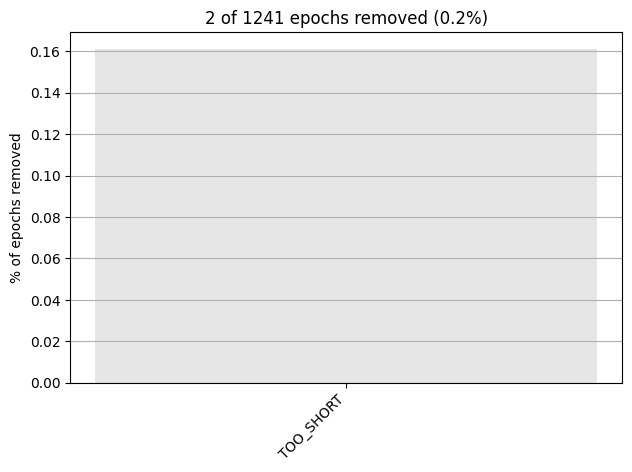

PD142.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD142.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 769535  =      0.000 ...  1502.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1503 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1503 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


191 bad epochs dropped


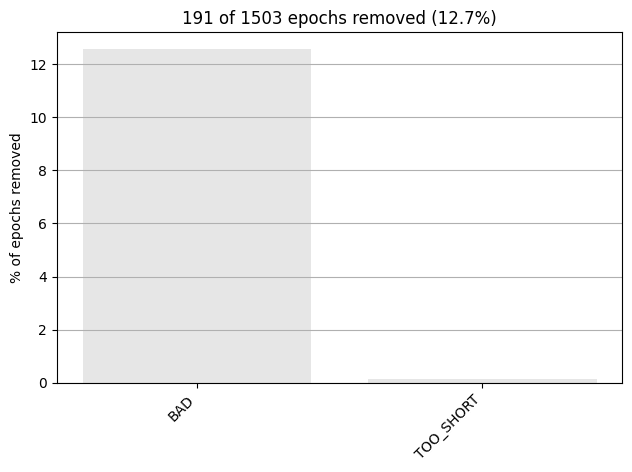

PD146.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD146.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 636927  =      0.000 ...  1243.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1244 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1244 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


10 bad epochs dropped


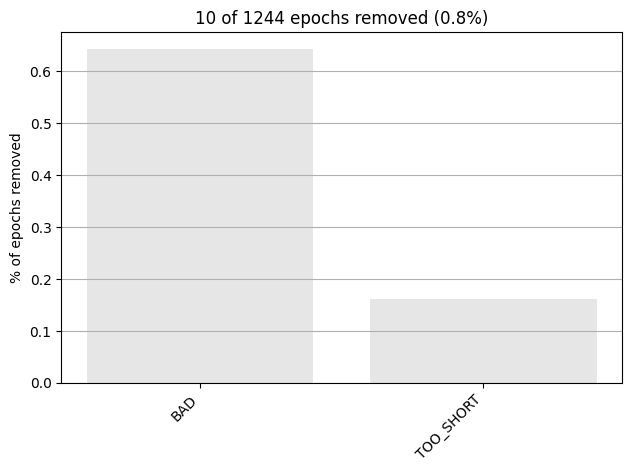

PD140.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD140.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 666623  =      0.000 ...  1301.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1302 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1302 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


12 bad epochs dropped


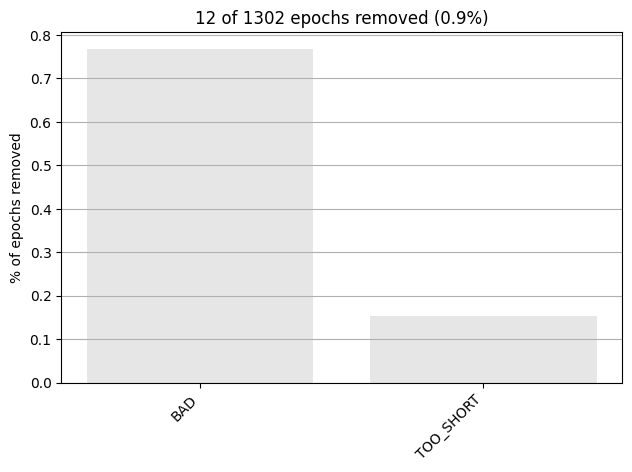

PD145.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD145.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 643583  =      0.000 ...  1256.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1257 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1257 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


13 bad epochs dropped


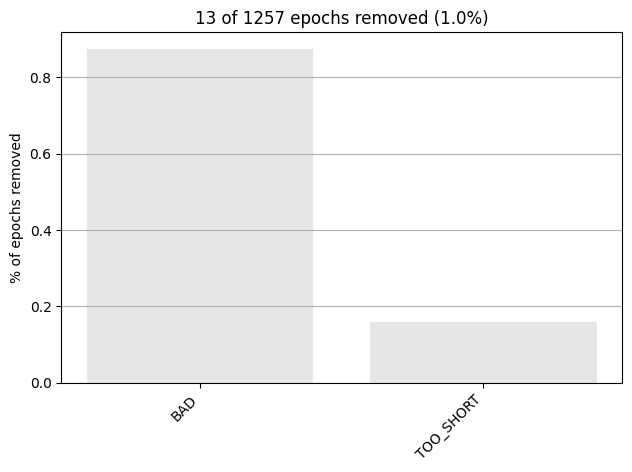

PD141.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD141.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 621567  =      0.000 ...  1213.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1214 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1214 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


13 bad epochs dropped


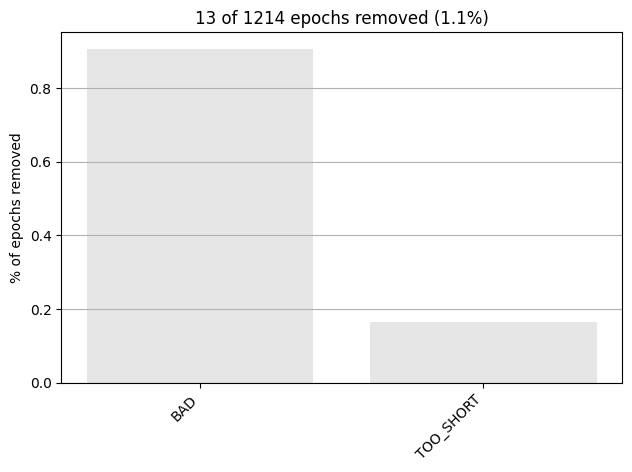

PD144.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD144.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 655871  =      0.000 ...  1280.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1281 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1281 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


18 bad epochs dropped


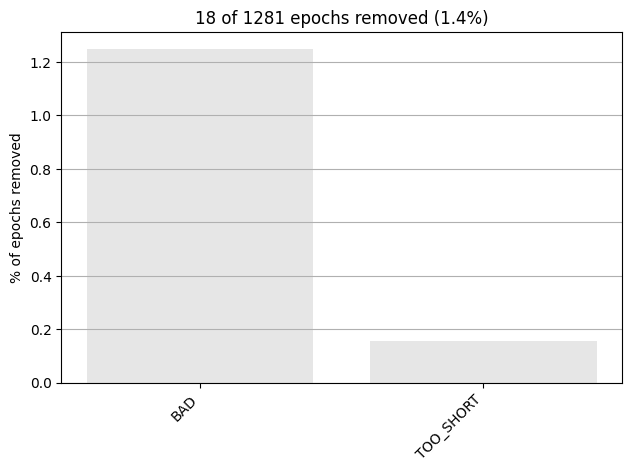

PD143.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD143.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 717823  =      0.000 ...  1401.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1402 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1402 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


170 bad epochs dropped


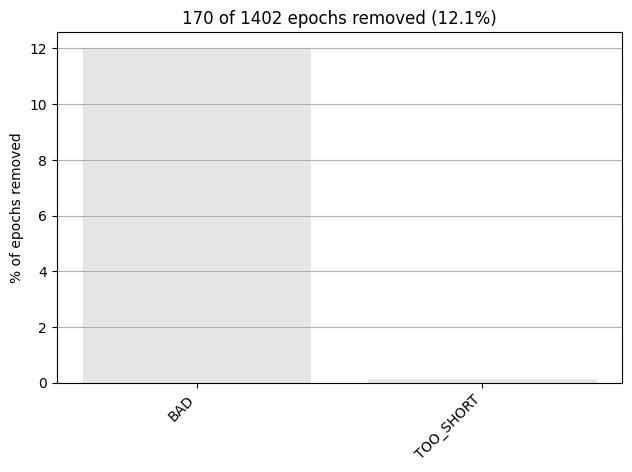

PD139.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD139.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 698367  =      0.000 ...  1363.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1364 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1364 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


124 bad epochs dropped


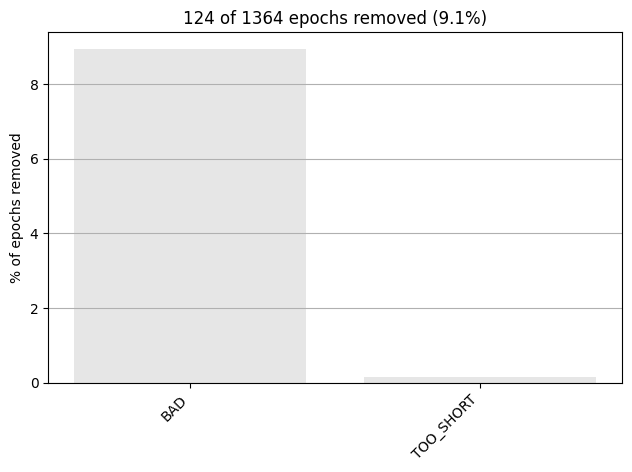

PD147.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD147.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 638975  =      0.000 ...  1247.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1248 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1248 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


46 bad epochs dropped


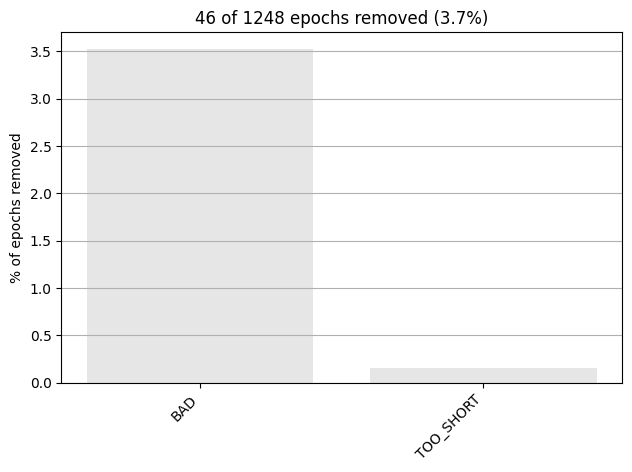

PD150.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD150.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671743  =      0.000 ...  1311.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1312 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1312 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


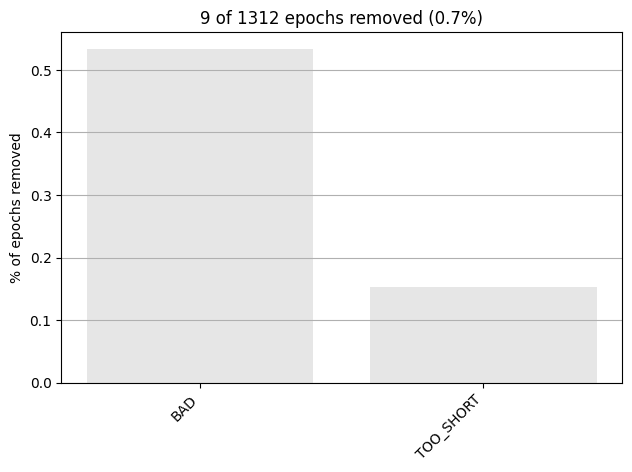

PD149.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD149.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 747007  =      0.000 ...  1458.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1459 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1459 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


168 bad epochs dropped


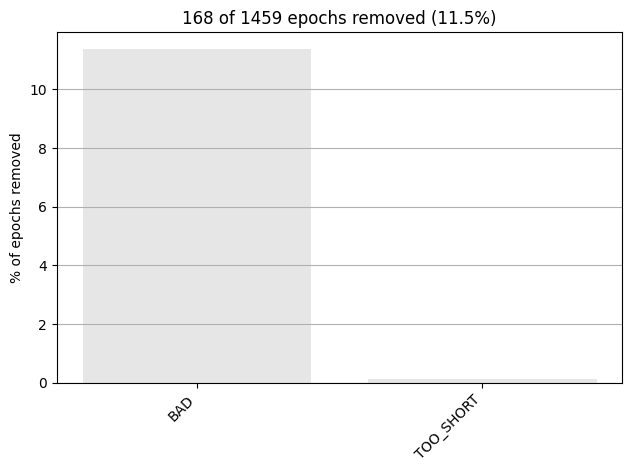

PD151.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD151.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 685567  =      0.000 ...  1338.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1339 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1339 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


106 bad epochs dropped


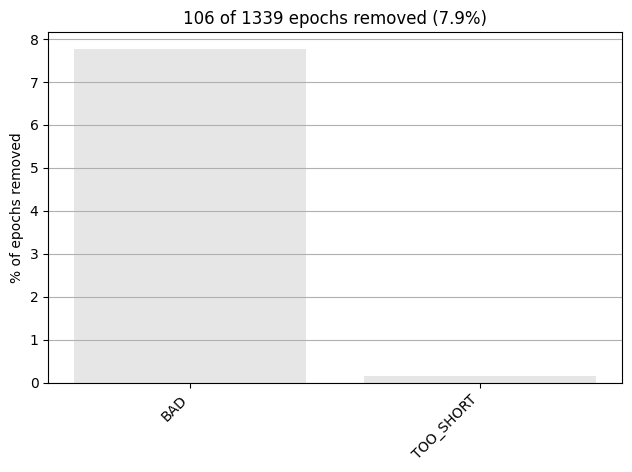

PD148.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD148.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 663039  =      0.000 ...  1294.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1295 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1295 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


34 bad epochs dropped


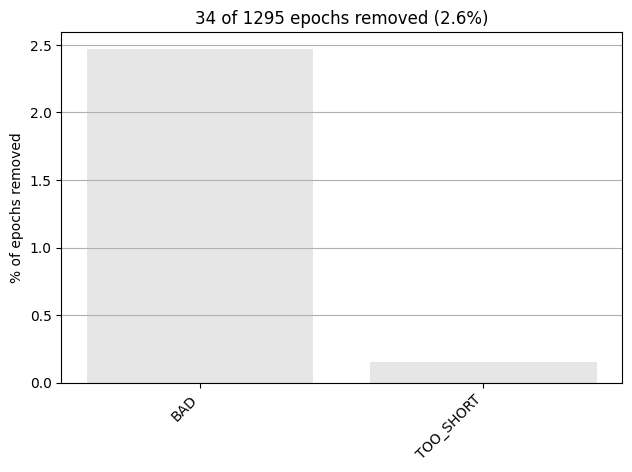

PD154.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD154.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 666111  =      0.000 ...  1300.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1301 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1301 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


10 bad epochs dropped


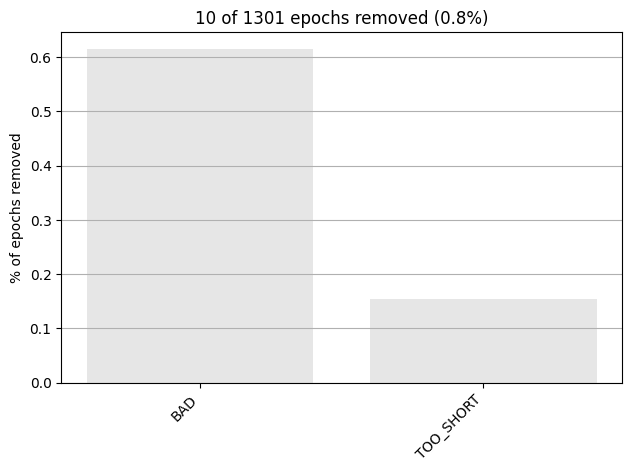

PD152.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 672767  =      0.000 ...  1313.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1314 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1314 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


113 bad epochs dropped


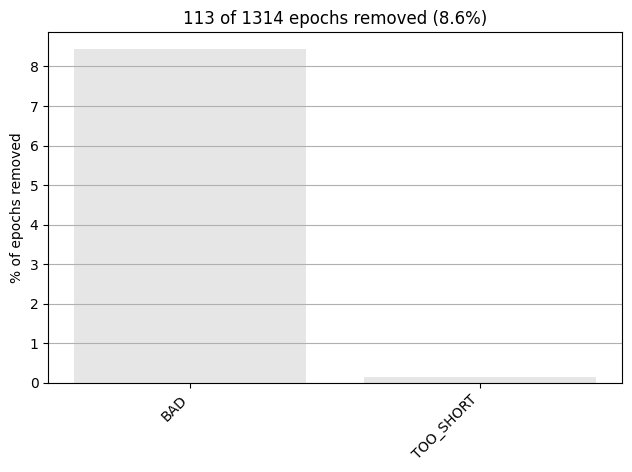

PD153.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 657407  =      0.000 ...  1283.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1284 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1284 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


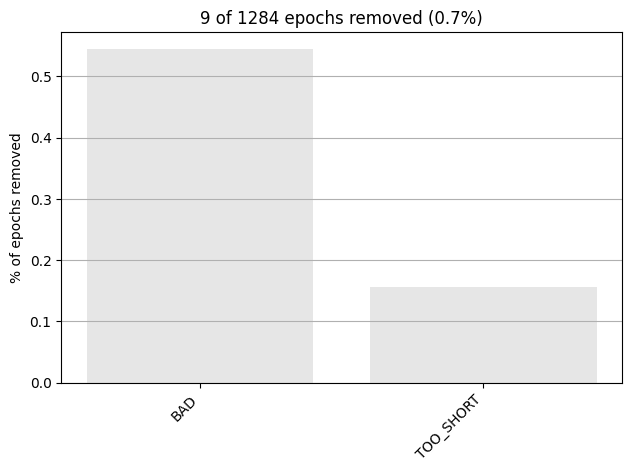

PD155.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD155.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 654847  =      0.000 ...  1278.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1279 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1279 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


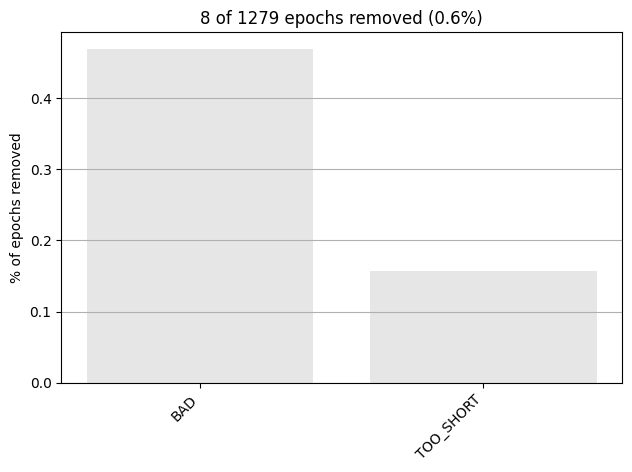

PD157.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD157.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 639999  =      0.000 ...  1249.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1250 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1250 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


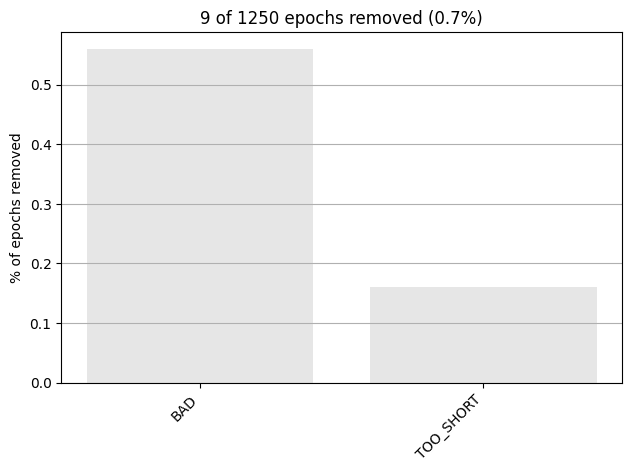

PD156.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD156.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 631295  =      0.000 ...  1232.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1233 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1233 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


15 bad epochs dropped


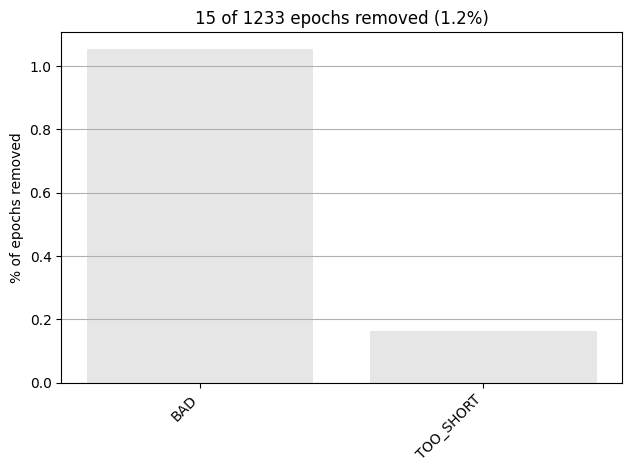

PD158.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD158.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 719871  =      0.000 ...  1405.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1406 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1406 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


39 bad epochs dropped


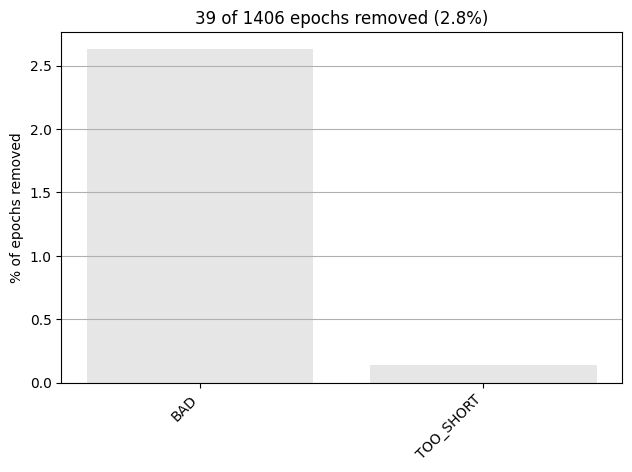

PD159.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD159.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 631807  =      0.000 ...  1233.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1234 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1234 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


41 bad epochs dropped


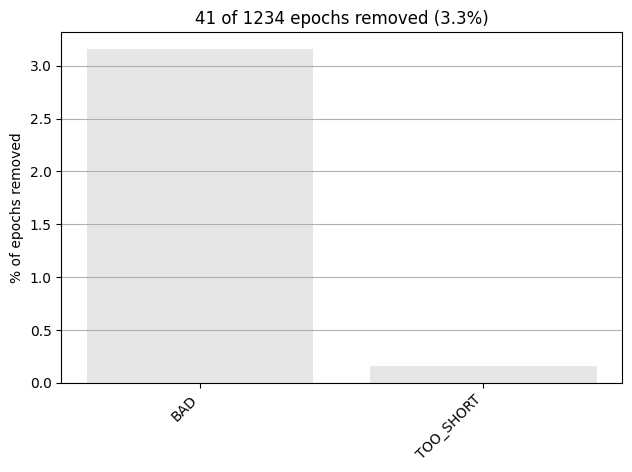

PD160.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD160.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 620031  =      0.000 ...  1210.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1211 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1211 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


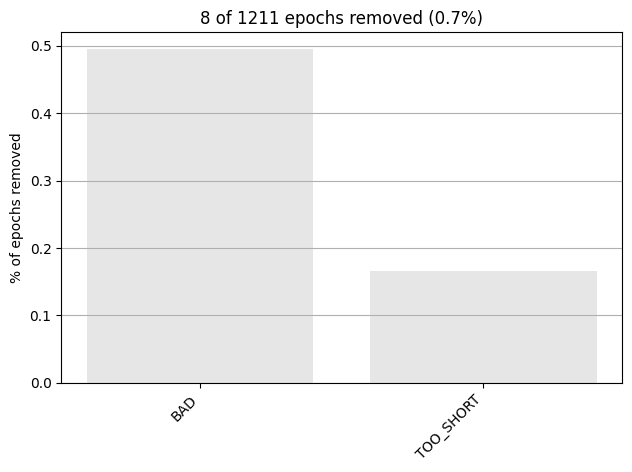

PD162.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD162.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 724479  =      0.000 ...  1414.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1415 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1415 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


195 bad epochs dropped


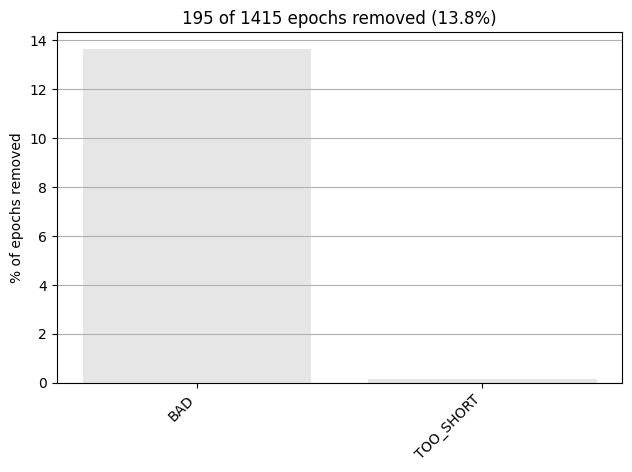

PD161.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD161.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 700415  =      0.000 ...  1367.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1368 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


18 bad epochs dropped


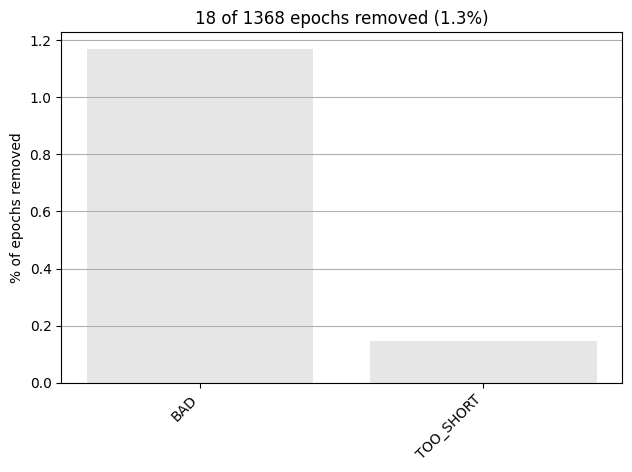

PD172.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD172.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 620031  =      0.000 ...  1210.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1211 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1211 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


9 bad epochs dropped


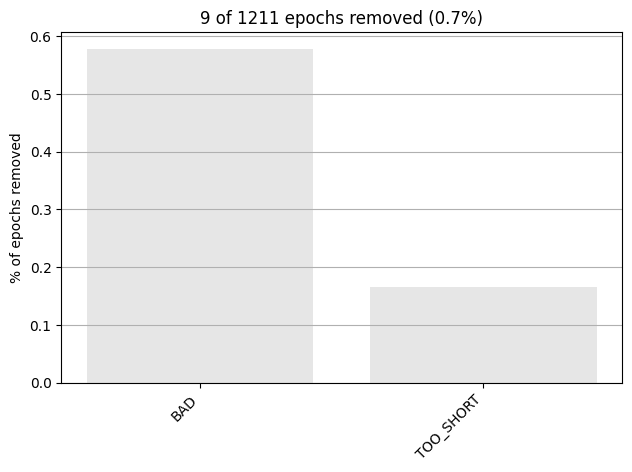

PD170.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD170.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 691199  =      0.000 ...  1349.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1350 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1350 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


90 bad epochs dropped


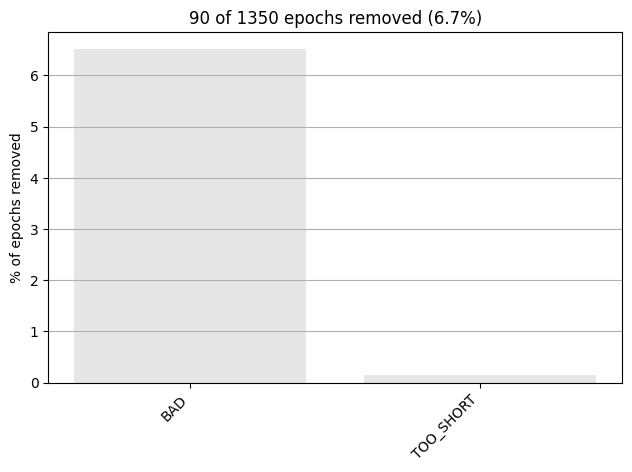

PD167.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD167.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 641023  =      0.000 ...  1251.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1252 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1252 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


35 bad epochs dropped


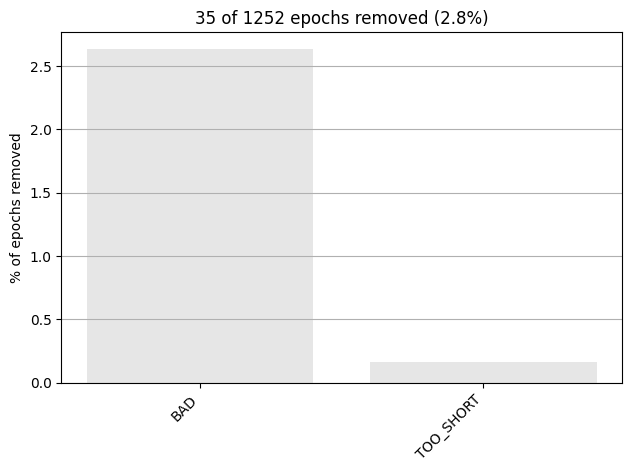

PD165.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD165.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 827903  =      0.000 ...  1616.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1617 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1617 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


414 bad epochs dropped


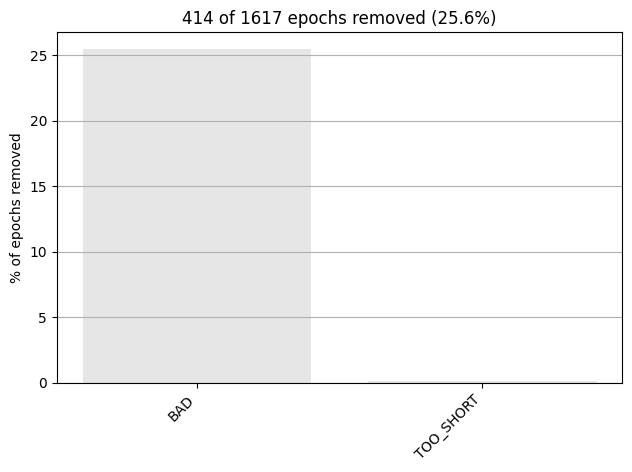

PD166.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD166.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 815103  =      0.000 ...  1591.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1592 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1592 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


281 bad epochs dropped


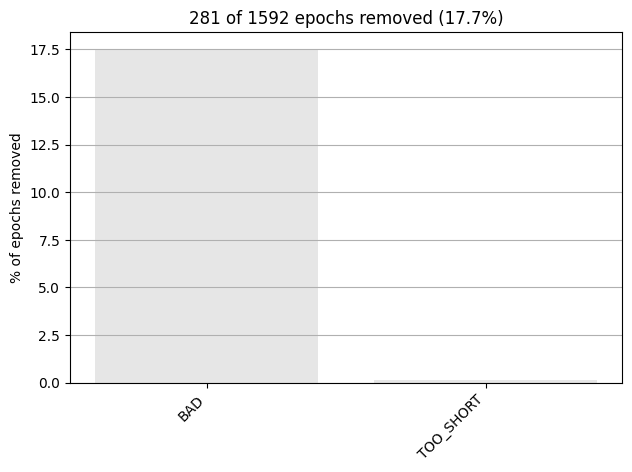

PD164.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD164.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 702463  =      0.000 ...  1371.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1372 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1372 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


174 bad epochs dropped


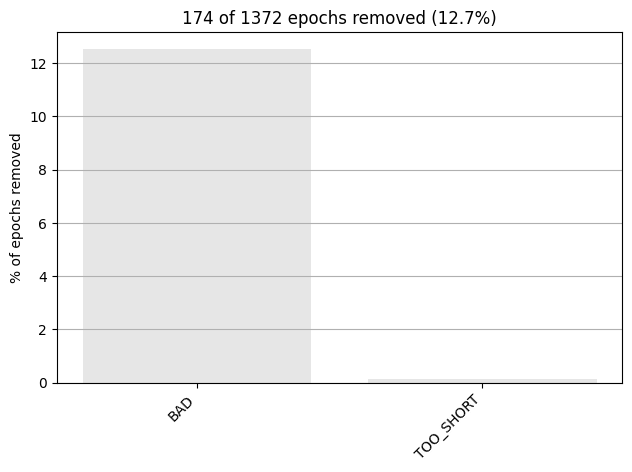

PD163.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD163.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 680959  =      0.000 ...  1329.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1330 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1330 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


36 bad epochs dropped


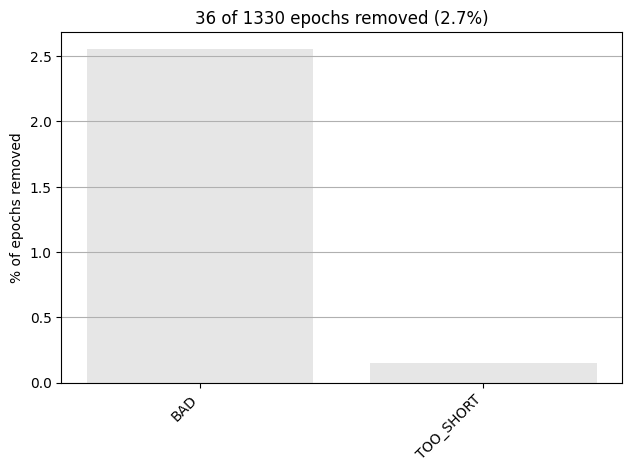

PD171.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD171.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617983  =      0.000 ...  1206.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1207 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1207 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


2 bad epochs dropped


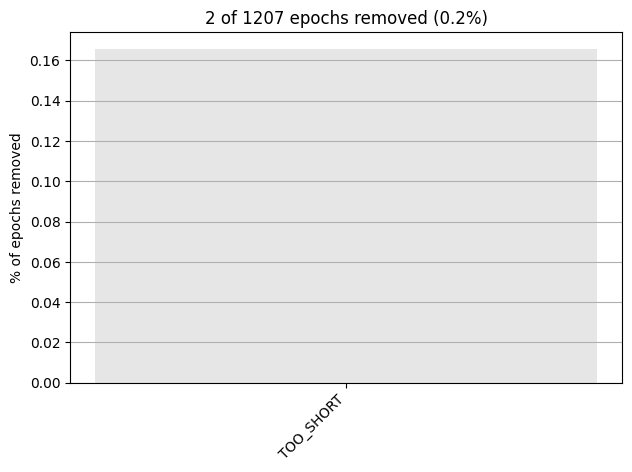

PD176.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD176.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302591  =      0.000 ...   590.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
591 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 591 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


104 bad epochs dropped


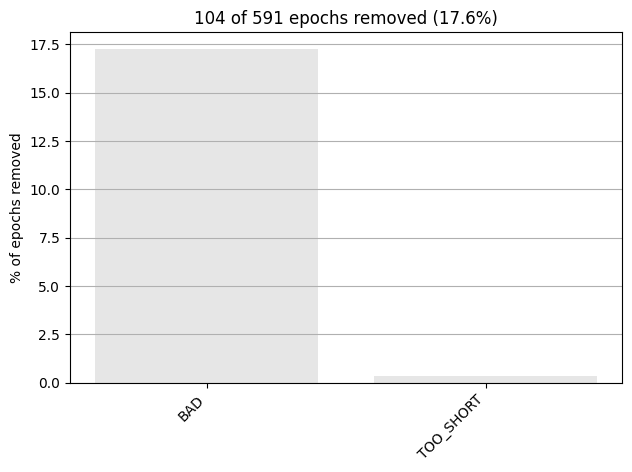

PD174.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD174.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 679423  =      0.000 ...  1326.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1327 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1327 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


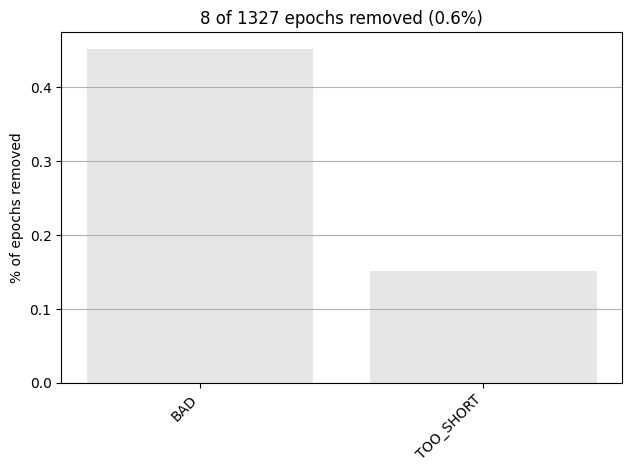

PD182.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD182.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619007  =      0.000 ...  1208.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1209 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1209 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


2 bad epochs dropped


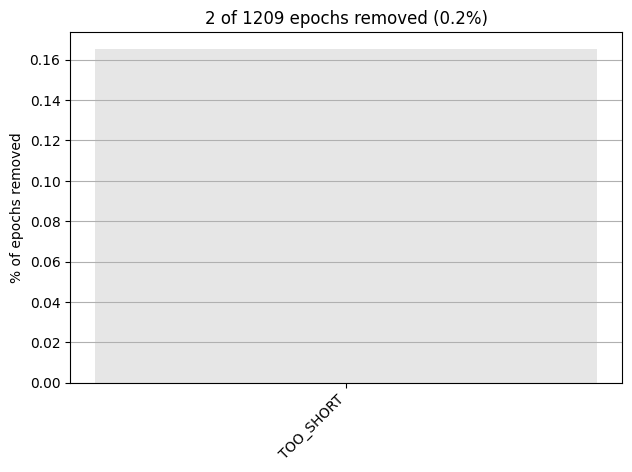

PD173.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD173.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 683519  =      0.000 ...  1334.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1335 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1335 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


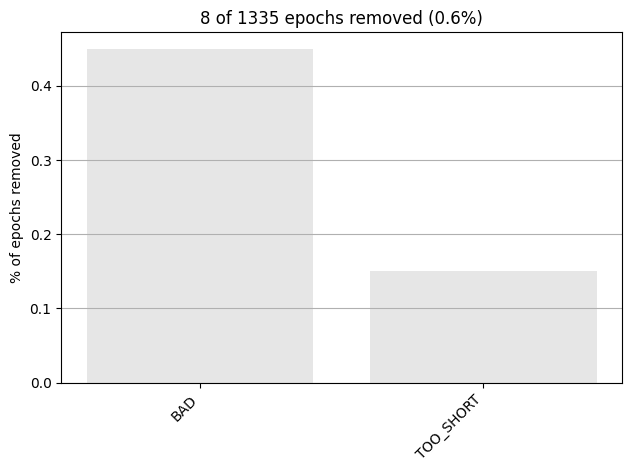

PD178.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD178.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 673791  =      0.000 ...  1315.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1316 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1316 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


26 bad epochs dropped


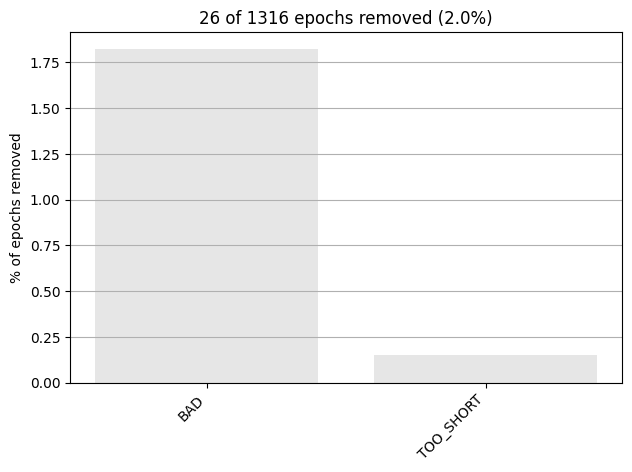

PD181.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD181.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 711679  =      0.000 ...  1389.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1390 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1390 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


79 bad epochs dropped


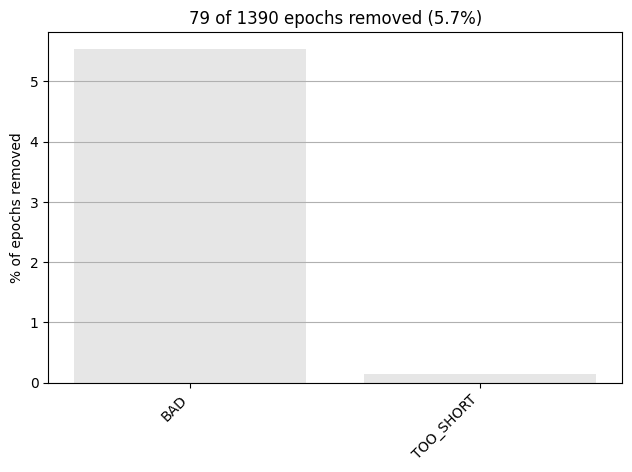

PD180.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD180.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 690687  =      0.000 ...  1348.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1349 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1349 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


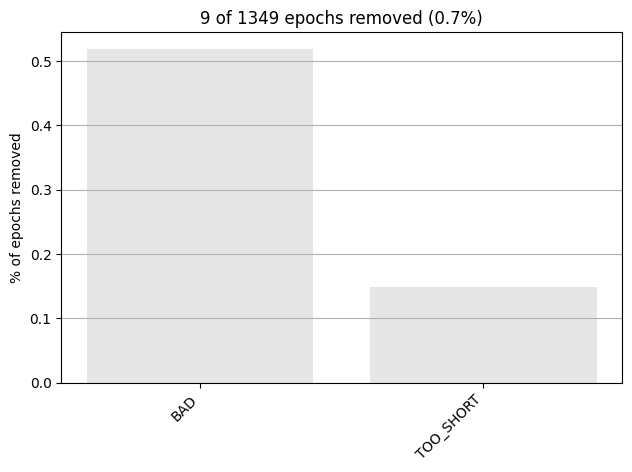

PD177.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD177.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 733695  =      0.000 ...  1432.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1433 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1433 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


71 bad epochs dropped


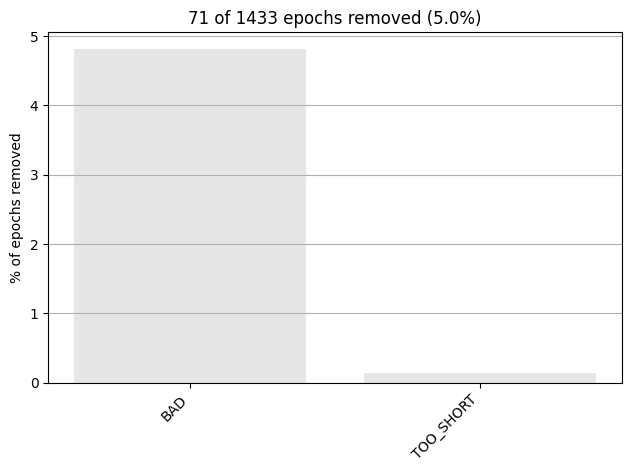

PD175.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD175.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617983  =      0.000 ...  1206.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1207 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1207 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


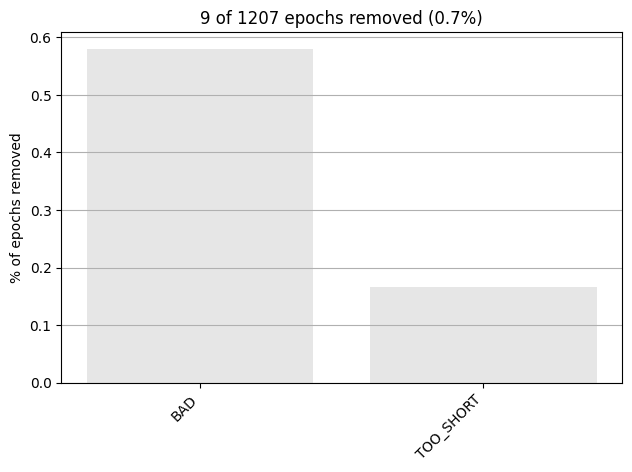

PD189.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD189.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 669695  =      0.000 ...  1307.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1308 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1308 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


103 bad epochs dropped


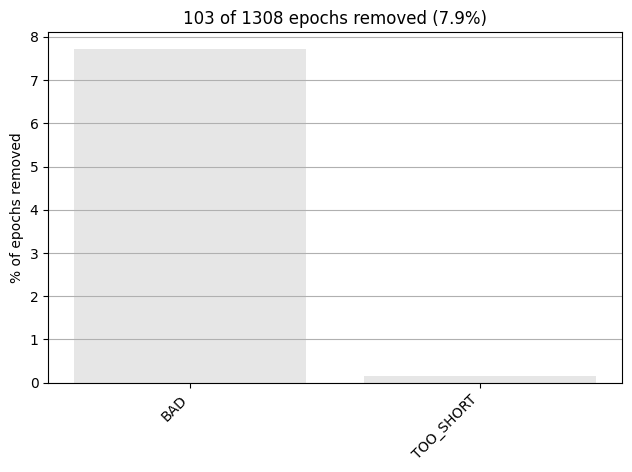

PD183.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD183.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 700415  =      0.000 ...  1367.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1368 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


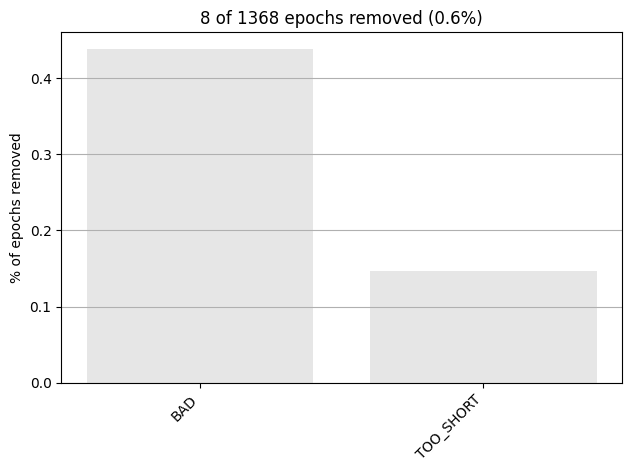

PD185.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD185.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 620031  =      0.000 ...  1210.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1211 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1211 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


8 bad epochs dropped


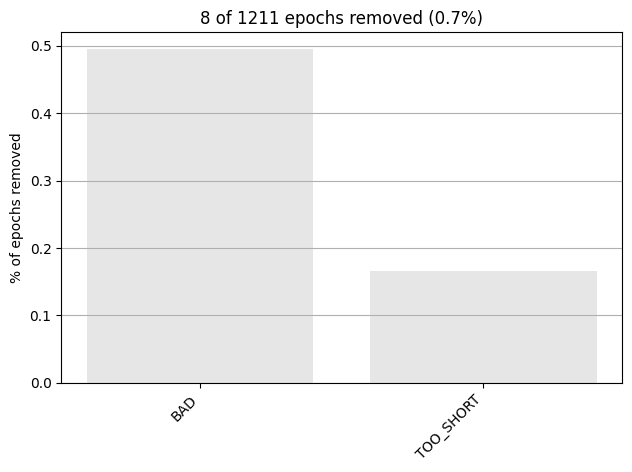

PD190.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD190.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 675839  =      0.000 ...  1319.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1320 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


2 bad epochs dropped


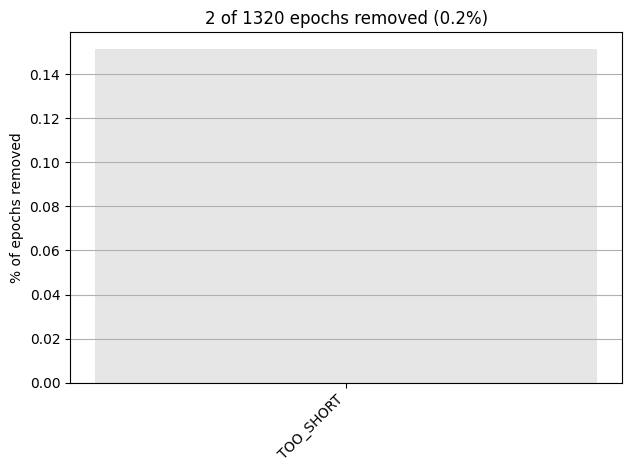

PD187.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD187.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 659967  =      0.000 ...  1288.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1289 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1289 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


2 bad epochs dropped


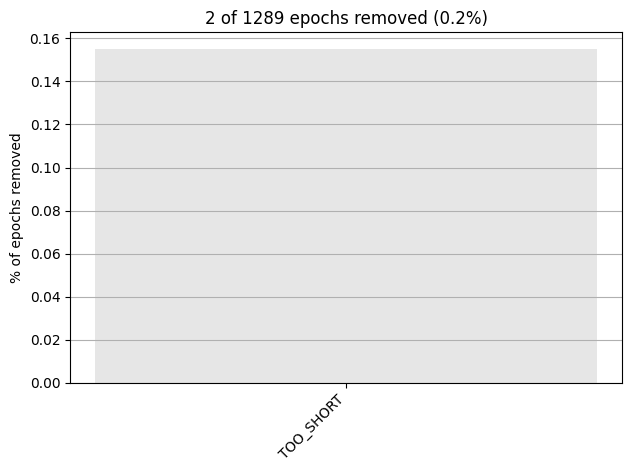

PD184.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD184.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619007  =      0.000 ...  1208.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1209 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1209 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


11 bad epochs dropped


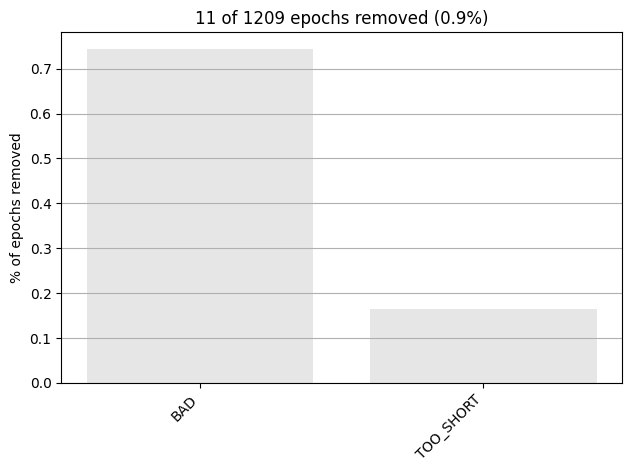

PD188.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD188.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749567  =      0.000 ...  1463.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1464 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1464 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


10 bad epochs dropped


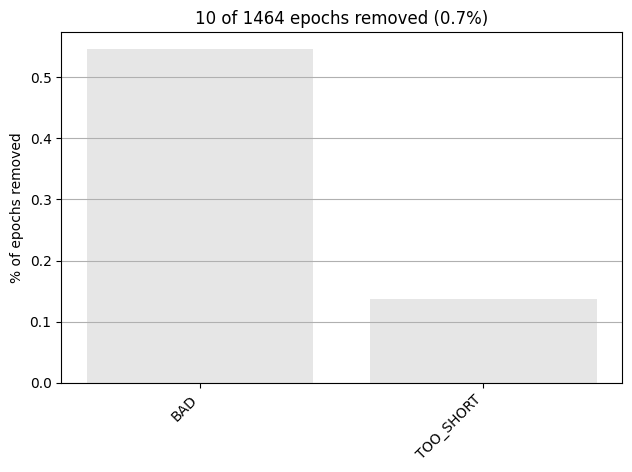

PD186.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD186.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 622079  =      0.000 ...  1214.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1215 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1215 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


35 bad epochs dropped


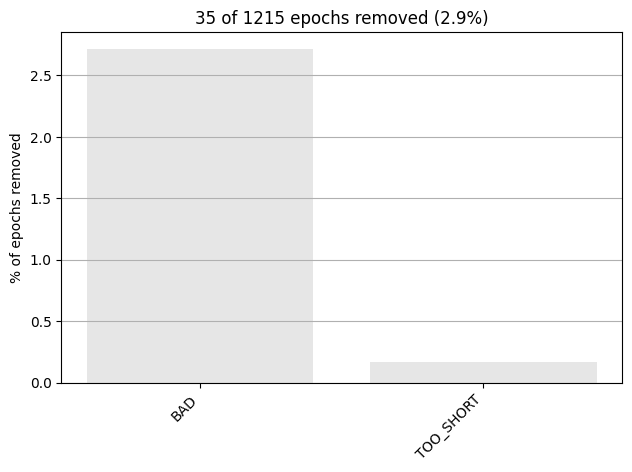

PD194.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD194.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 398847  =      0.000 ...   778.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
779 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 779 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


21 bad epochs dropped


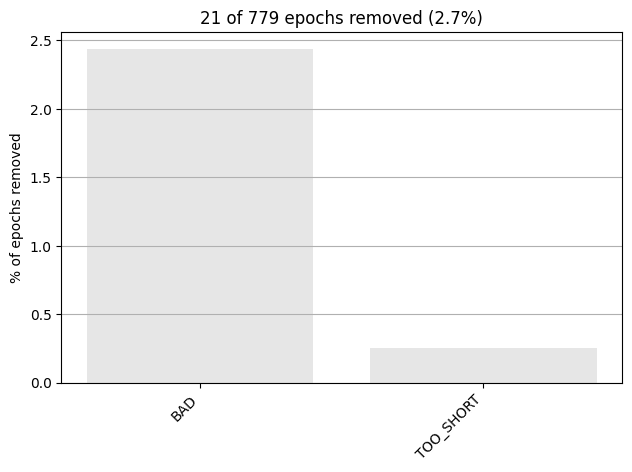

PD196.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD196.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 897535  =      0.000 ...  1752.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1753 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1753 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


394 bad epochs dropped


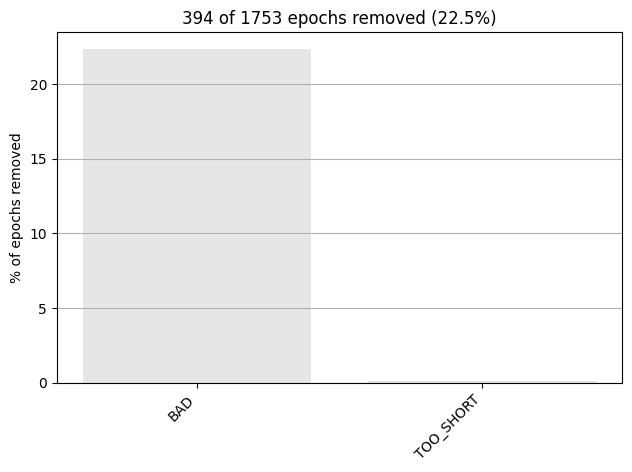

PD192.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 628223  =      0.000 ...  1226.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1227 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1227 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


11 bad epochs dropped


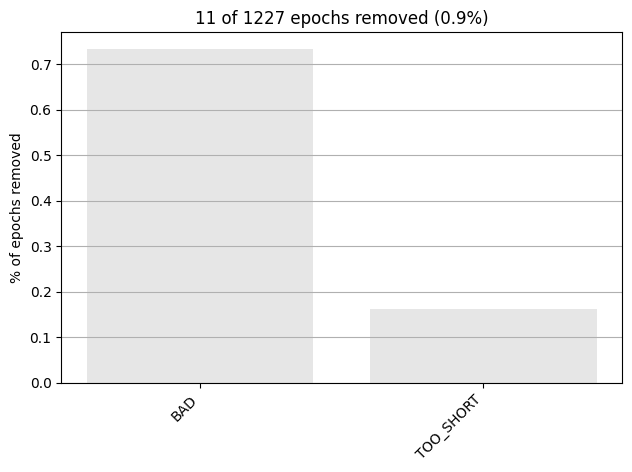

PD195.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD195.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 610815  =      0.000 ...  1192.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1193 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1193 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


11 bad epochs dropped


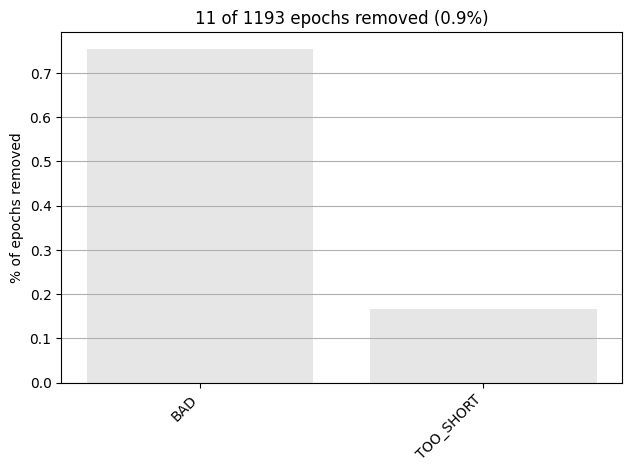

PD193.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD193.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 605183  =      0.000 ...  1181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1182 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1182 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


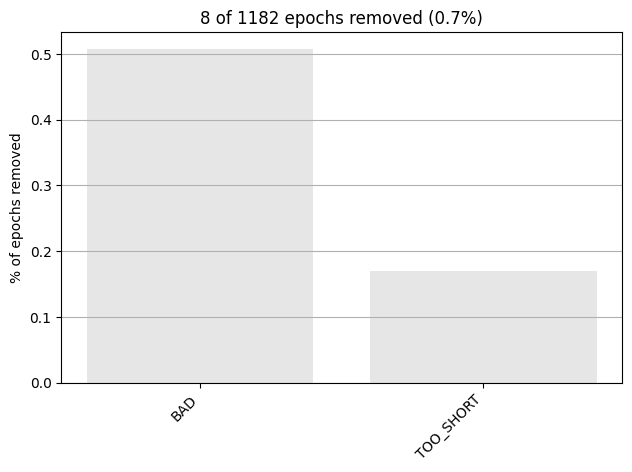

PD191.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD191.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619007  =      0.000 ...  1208.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1209 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1209 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


8 bad epochs dropped


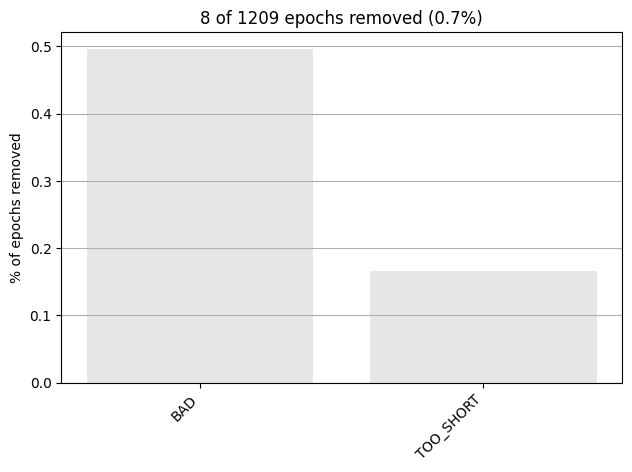

PD197.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD197.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 991743  =      0.000 ...  1936.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1937 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1937 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


702 bad epochs dropped


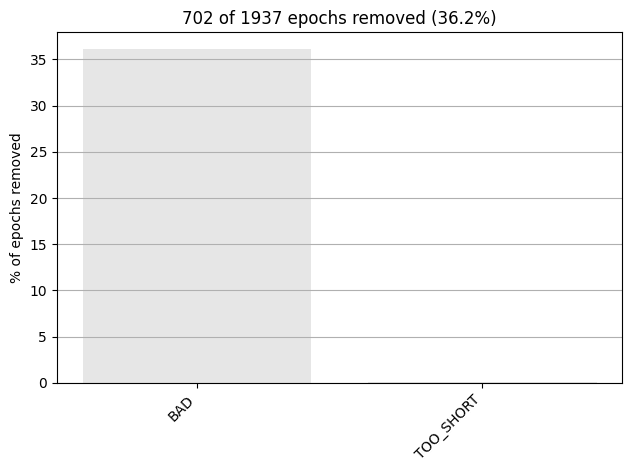

PD198.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD198.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 691199  =      0.000 ...  1349.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1350 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1350 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


116 bad epochs dropped


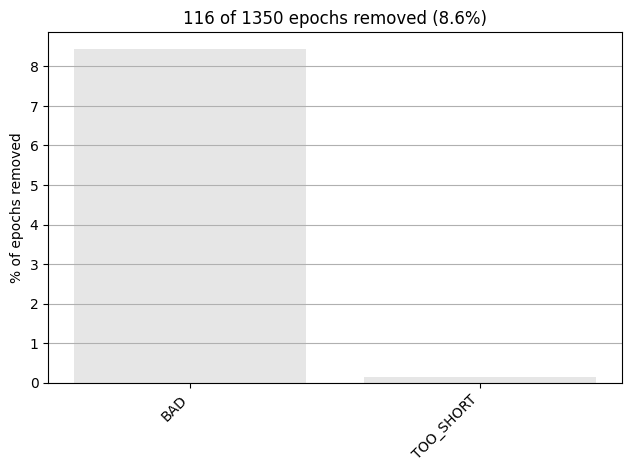

PD199.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD199.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 629247  =      0.000 ...  1228.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1229 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1229 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


2 bad epochs dropped


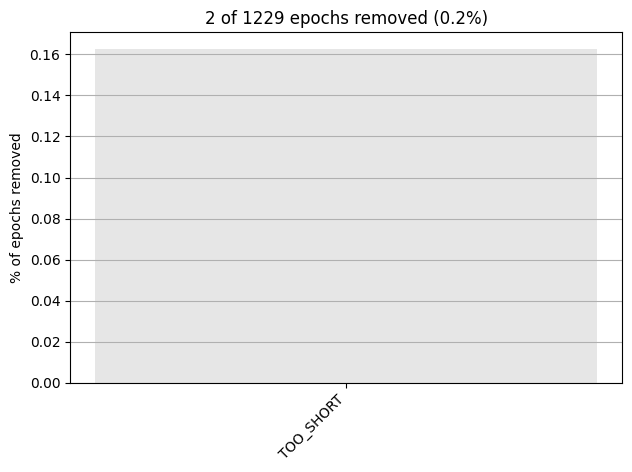

PD202.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD202.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 692735  =      0.000 ...  1352.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1353 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1353 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


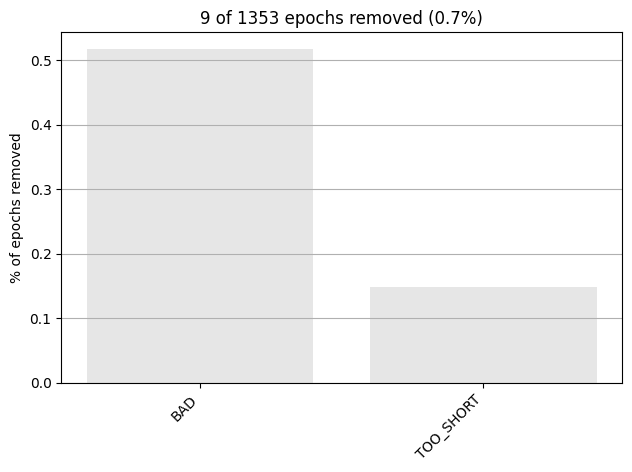

PD201.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD201.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 620543  =      0.000 ...  1211.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1212 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1212 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


17 bad epochs dropped


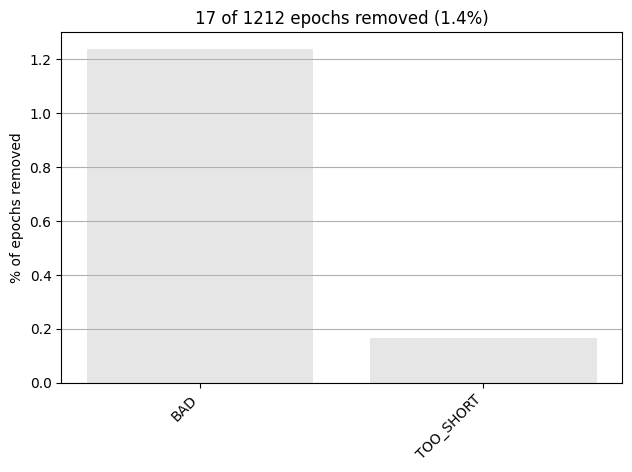

PD200.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD200.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 625663  =      0.000 ...  1221.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1222 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1222 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


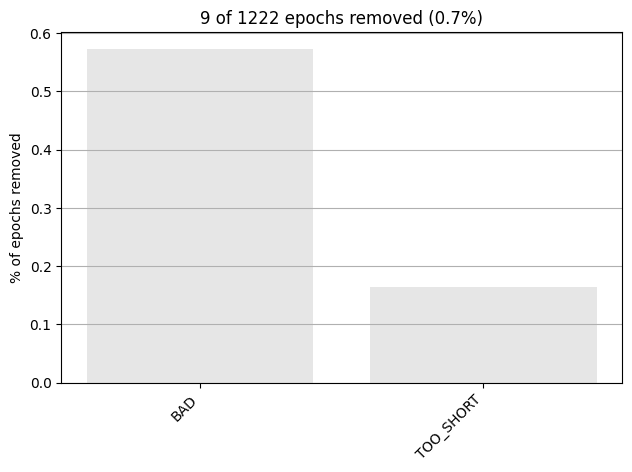

PD204.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD204.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 624639  =      0.000 ...  1219.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1220 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1220 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


13 bad epochs dropped


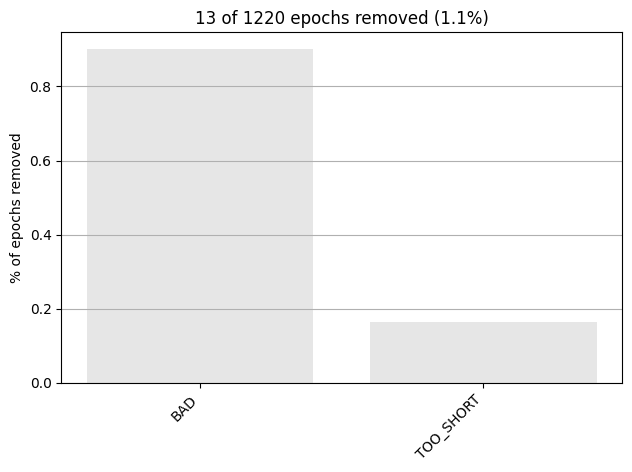

PD203.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD203.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 673279  =      0.000 ...  1314.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1315 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1315 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


76 bad epochs dropped


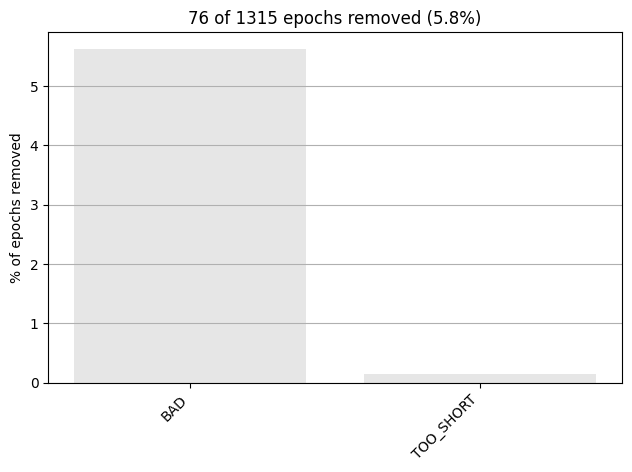

PD209.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD209.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 639999  =      0.000 ...  1249.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1250 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1250 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


53 bad epochs dropped


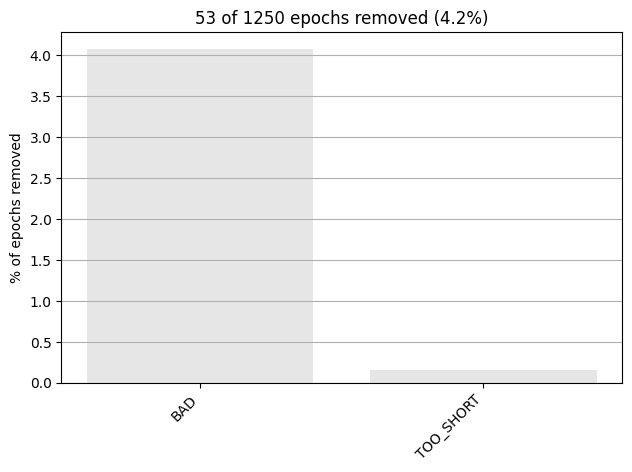

PD205.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD205.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 658431  =      0.000 ...  1285.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1286 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1286 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


12 bad epochs dropped


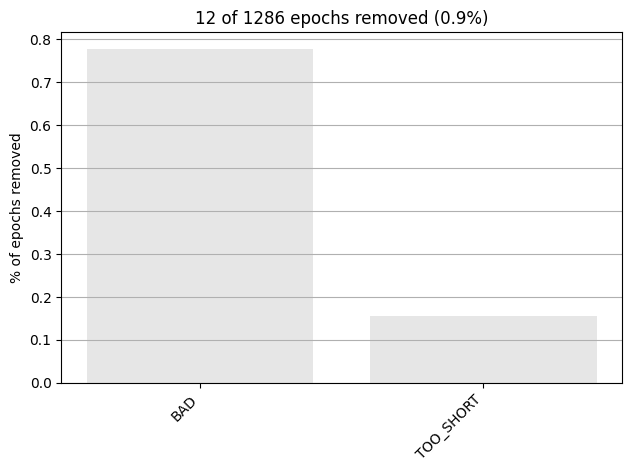

PD211.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD211.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 644095  =      0.000 ...  1257.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1258 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1258 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


30 bad epochs dropped


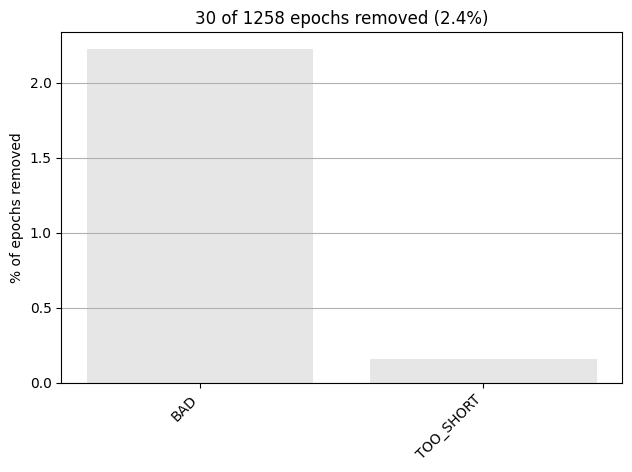

PD207.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD207.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 624639  =      0.000 ...  1219.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1220 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1220 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


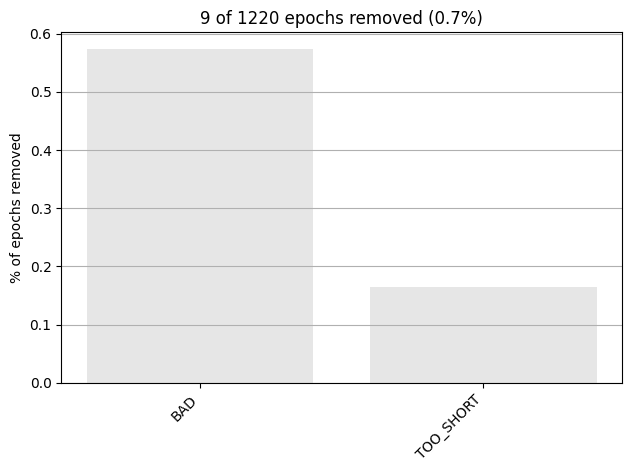

PD210.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD210.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 624127  =      0.000 ...  1218.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1219 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1219 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


9 bad epochs dropped


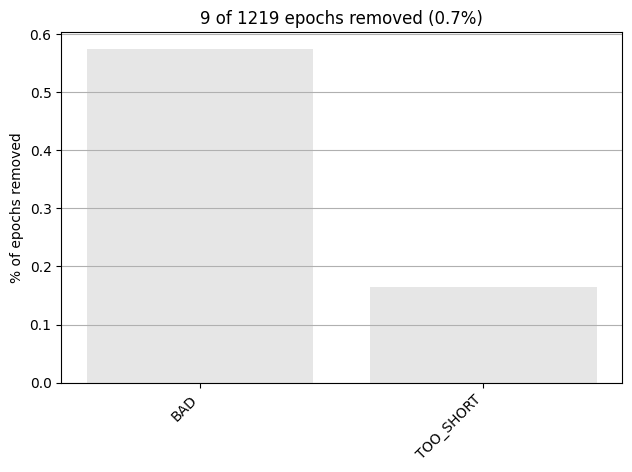

PD212.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD212.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 788479  =      0.000 ...  1539.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1540 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1540 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


205 bad epochs dropped


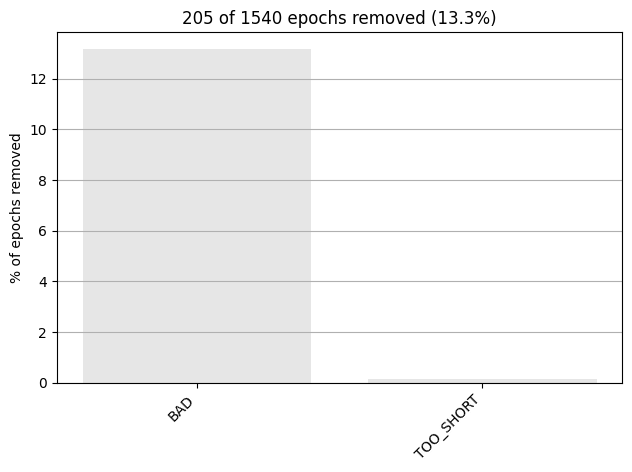

PD208.edf
Extracting EDF parameters from /content/drive/MyDrive/dyplom/EEG/PD208.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 677375  =      0.000 ...  1322.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
1323 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1323 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


11 bad epochs dropped


In [ ]:
data = load_epochs_from_dir('/content/drive/MyDrive/dyplom/EEG',labels)
df = pd.DataFrame(data, columns=['value', 'label'])
df.to_csv('data.csv', index=False)

In [ ]:
psd = psds([epochs for epochs, label in data], [label for epochs, label in data])
df = pd.DataFrame(psd, columns=['psds', 'label'])
df.to_csv('psd.csv', index=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split([x[0] for x in psd], [x[1] for x in psd], test_size=0.2, random_state=42)
X_train_2d = np.array([x[0] for x in X_train]).reshape(len(X_train), -1)
X_test_2d = np.array([x[0] for x in X_test]).reshape(len(X_test), -1)
y_train=np.array(y_train)
y_train=y_train.transpose()
y_test=np.array(y_test)
y_test=y_test.transpose()
svm = SVC(kernel='linear', C=1, random_state=42)

In [ ]:
print(X_test_2d.shape)
print(X_train_2d.shape)

(26755, 10)
(107017, 10)


In [ ]:
svm.fit(X_train_2d, y_train)

SVC(C=1, kernel='linear', random_state=42)

In [ ]:
y_pred = svm.predict(X_test_2d)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.4377873294711269
